In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import numpy as np
import ast
from numpy import mean

# visualization
import matplotlib.pyplot as plt

# model training selection
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedStratifiedKFold

# pipeline
# from sklearn.pipeline import Pipeline

# chosen models
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif #detect collinearity

# data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## model evaluation metrics
from collections import Counter
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse

# important cols
import shap
shap.initjs()

### setup

In [2]:
target_col = 'total_funding_amount_usd'

### funcs

In [155]:
# somehow the sklearn pipeline dont work
def pipeline(df, scale_y=True):
    # get data
    X = df.drop(columns=target_col)
    y = df[target_col]
    ## split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # feature scaling
    ## x scaler
    scaler = MinMaxScaler().fit(X_train) #performs better than StandardScaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if scale_y==False:
        # run model
        model = OLS(y_train, X_train_scaled)
        results = model.fit()
    else:
        ## y scaler
        scaler2 = MinMaxScaler().fit(np.array(y_train).reshape(-1, 1))
        y_train_scaled = scaler2.transform(np.array(y_train).reshape(-1, 1))
        # run model
        model = OLS(y_train_scaled, X_train_scaled)
        results = model.fit()
    # results.params
    # results.summary()
    
    # r squared value has to be over 60%
    print(f'r^2={results.rsquared}')
    
    # all coeff should be significant
    print(f'pvals: {Counter(results.pvalues<0.05)}')
    
    return results

In [43]:
def get_results_table(df, results):
    
    # get table with coeffs and pvals
    results_as_html = results.summary().tables[1].as_html()
    df_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
    
    # rename index to col names
    index_lst = list(df_results.index)
    col_names = {}
    for i in range(df_results.shape[0]):
        if index_lst[i] == 'const':
            pass
        else:
            col_names[index_lst[i]] = df.columns[i]
    df_results.rename(index=col_names, inplace=True)
    
    return df_results

## ols
picking up from ols_v4: **r^2 is 65% and 49 coeffs significant!**

highlights
- `%female` is still picked up :)
- high level industry cols were not picked up, but `top_investors_count` was!!
- compared to v3.2, keeping industries is better than keeping industry groups
- location picked up is still chinese states mainly

In [150]:
# # data
# df = pd.read_csv('../data/feature_engineering/combined_feng_v10.csv', index_col=0)

# sig_cols_v4 = ['number_of_funding_rounds', '%female', 'top_investors_count', 'beijing', 'chinese_state', 
#                'guangdong', 'shanghai', 'estimated_revenue_range', 'number_of_employees', 'active_tech_count',
#                'patents_granted', 'trademarks_registered', 'a/b testing', 'alternative medicine', 
#                'environmental consulting', 'film', 'franchise', 'health care', 
#                'industrial automation',  'insurance', 'mhealth', 'mobile devices', 'pc games', 
#                'ticketing', 'video advertising', 'warehousing', 'web browsers', 'alibaba group', 
#                'cmb international capital corporation', 'idg capital', 'sbi group', 'lenovo', 'warburg pincus', 
#                'goldman sachs', 'cicc', 'ant group', 'cdh investments', 'lightspeed china partners', 
#                'morningside group', 'non-fungible chan', 'seed capital', 'preseed ventures', 'bdmi', 
#                'alchemist accelerator', 'kickstart', 'peterson ventures']

# df = df[sig_cols_v4+[target_col]]
# df.shape

In [151]:
# results = pipeline(df, scale_y=False)

In [152]:
# df_results = get_results_table(df, results)
# df_results = df_results.sort_values(by='coef', ascending=False)
# df_results

In [103]:
# df_results.to_csv('ols_final.csv')

In [153]:
# data: location encodes as china, europe, us
df = pd.read_csv('../data/feature_engineering/combined_feng_v14.0.csv', index_col=0)

sig_cols_v6 = ['%female', 'china', 'estimated_revenue_range', 'patents_granted',
               'trademarks_registered', 'tencent', 'alibaba group',
               'cmb international capital corporation', 'sbi group',
               'lenovo', 'shenzhen capital group', 'warburg pincus', 
               'goldman sachs', 'yf capital', 'cicc', 'morningside group',
               'sierra ventures', 'yunqi partners', 'fortune venture capital',
               'oriza holdings', 'non-fungible chan', 'seed capital',
               'credo ventures', 'preseed ventures', 'marc bell ventures',
               'kairos ventures', 'bdmi', 'alchemist accelerator',
               'tdf ventures', 'foundry group', 'endeavor catalyst',
               'autonomous vehicles', 'logistics', 'pc games', 'marketing',
               'trading platform', 'online portals', 'news', 'video streaming',
               'consumer goods', 'mobile devices', 'cloud data services', 
               'video advertising']

df = df[sig_cols_v6+[target_col]]
df.shape

(3000, 44)

In [156]:
results = pipeline(df, scale_y=False)

r^2=0.7847092330878124
pvals: Counter({True: 43})


In [180]:
3.505000e+07

35050000.0

In [157]:
df_results = get_results_table(df, results)
df_results = df_results.sort_values(by='coef', ascending=False)
df_results

,coef,std err,t,P>|t|,[0.025,0.975]
sbi group,1.097000e+09,2.700000e+07,40.662,0.000,1.040000e+09,1.150000e+09
preseed ventures,1.085000e+09,4.010000e+07,27.025,0.000,1.010000e+09,1.160000e+09
alchemist accelerator,1.078000e+09,4.630000e+07,23.271,0.000,9.870000e+08,1.170000e+09
lenovo,7.447000e+08,2.400000e+07,30.996,0.000,6.980000e+08,7.920000e+08
warburg pincus,5.140000e+08,2.200000e+07,23.340,0.000,4.710000e+08,5.570000e+08
alibaba group,3.266000e+08,2.120000e+07,15.428,0.000,2.850000e+08,3.680000e+08
endeavor catalyst,1.934000e+08,3.310000e+07,5.847,0.000,1.290000e+08,2.580000e+08
patents_granted,1.626000e+08,2.620000e+07,6.208,0.000,1.110000e+08,2.140000e+08
goldman sachs,1.396000e+08,1.720000e+07,8.114,0.000,1.060000e+08,1.730000e+08
cmb international capital corporation,1.165000e+08,2.190000e+07,5.333,0.000,7.370000e+07,1.590000e+08


In [158]:
# df_results.to_csv('ols_final.csv')

In [99]:
df['number_of_funding_rounds'].value_counts()[:5]

1    1066
2     886
3     548
4     251
5     119
Name: number_of_funding_rounds, dtype: int64

In [143]:
2.612016e+08

261201600.0

In [136]:
three.describe()

count    5.480000e+02
mean     1.184374e+07
std      1.625522e+07
min      2.002000e+06
25%      5.520447e+06
50%      8.400000e+06
75%      1.328500e+07
max      2.612016e+08
Name: total_funding_amount_usd, dtype: float64

In [102]:
one = df[df['number_of_funding_rounds']==1]['total_funding_amount_usd'].reset_index(drop=True)
two = df[df['number_of_funding_rounds']==2]['total_funding_amount_usd'].reset_index(drop=True)
three = df[df['number_of_funding_rounds']==3]['total_funding_amount_usd'].reset_index(drop=True)
four = df[df['number_of_funding_rounds']==4]['total_funding_amount_usd'].reset_index(drop=True)
five = df[df['number_of_funding_rounds']==5]['total_funding_amount_usd'].reset_index(drop=True)
df_rounds = pd.DataFrame({'1':one, '2':two, '3':three, '4':four, '5':five})

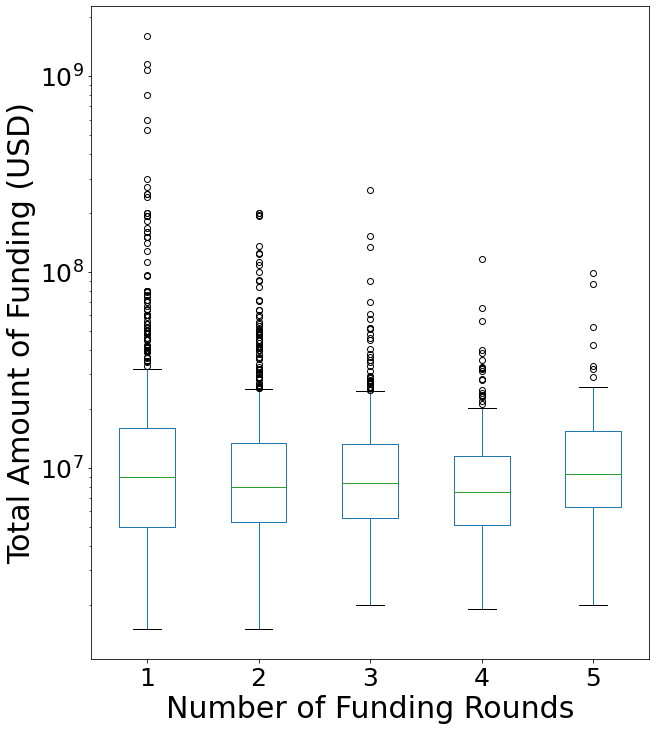

In [119]:
plt.figure(figsize=(10,12))
df_rounds.boxplot()
plt.xlabel('Number of Funding Rounds', fontsize=30)
plt.ylabel('Total Amount of Funding (USD)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.yscale('log')
plt.grid(False)
# plt.savefig('funding_box_rounds.png')

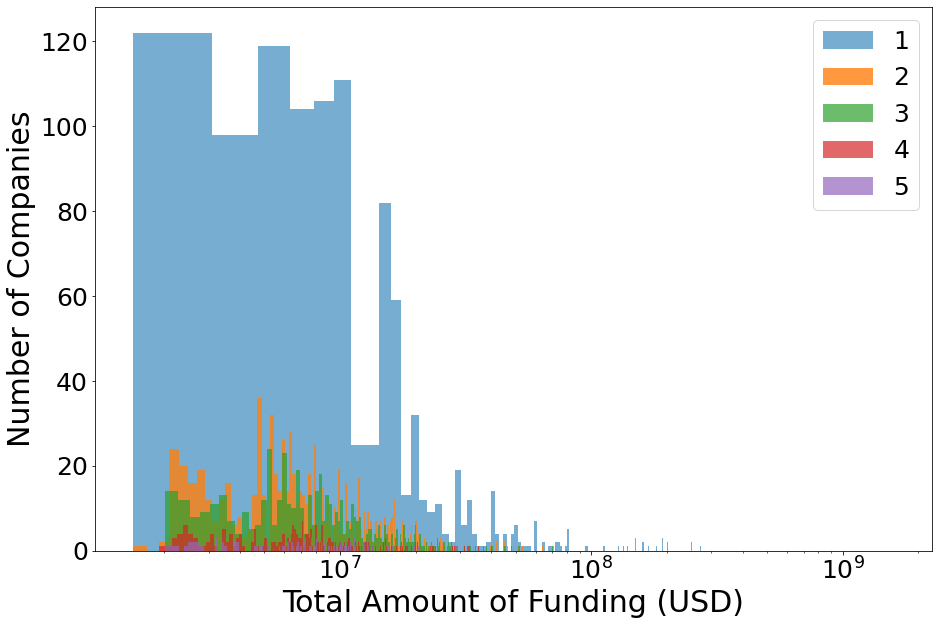

In [118]:
BINS = 1000
plt.figure(figsize=(15,10))
df_rounds['1'].hist(bins=BINS, alpha=0.6, label='1')
df_rounds['2'].hist(bins=BINS, alpha=0.8, label='2')
df_rounds['3'].hist(bins=BINS, alpha=0.7, label='3')
df_rounds['4'].hist(bins=BINS, alpha=0.7, label='4')
df_rounds['5'].hist(bins=BINS, alpha=0.7, label='5')
plt.xlabel('Total Amount of Funding (USD)', fontsize=30)
plt.ylabel('Number of Companies', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale('log')
plt.grid(False)
plt.legend(fontsize=25)
# plt.savefig('funding_hist_rounds.png')

### by descending order & by category

`total_funding_amount` 

#### investors
= 7.819000e+08 * `lenovo` + 4.385000e+08 * `sbi group` + 3.243000e+08 * `warburg pincus` + 2.907000e+08 * `preseed ventures` + 2.862000e+08 * `kickstart` + 2.759000e+08 * `alibaba group` + 1.560000e+08 * `alchemist accelerator` + 1.320000e+08 * `cicc` + 1.275000e+08 * `non-fungible chan` + 1.192000e+08 * `goldman sachs` + 1.117000e+08 * `cmb international capital corporation` + 7.513000e+07 * `ant group` + 6.988000e+07 * `bdmi` + 6.238000e+07 * `cdh investments` + 4.903000e+07 * `lightspeed china partners` + 2.916000e+07 * `idg capital` 

\- 1.435000e+08 * `peterson ventures` - 2.492000e+08 * `morningside group` - 2.892000e+08 * `seed capital`

#### industry
\+ 2.323000e+08 * `warehousing` + 9.753000e+07 * `alternative medicine` + 7.389000e+07 * `ticketing` + 5.605000e+07 * `environmental consulting` + 3.406000e+07 * `pc games` + 3.317000e+07 * `industrial automation` + 3.217000e+07 * `film` + 2.524000e+07 * `insurance` + 1.662000e+07 * `areospace` + 1.530000e+07 * `cloud data services` + 6.578000e+06 * `health care` + 6.084000e-07 * `lead management`

\- 2.487000e+07 * `mhealth` - 3.845000e+07 * `mobile devices` - 5.695000e+07 * `video advertising` - 1.435000e+08 * `a/b testing` - 2.759000e+08 * `web browsers`

#### numbers
\+ 1.422000e+08 * `patents_granted`  + 6.361000e+07 * `trademarks_registered` + 5.096000e+07 * `estimated_revenue_range` + 2.651000e+07 * `number_of_employees` 

\- 1.469000e+07 * `number_of_funding_rounds` - 1.715000e+07 * `active_tech_count`

#### location
\+ 2.072000e+07 * `shanghai` + 1.318000e+07	 * `guangdong` + 1.231000e+07 * `chinese_state` + 1.006000e+07 * `beijing`  

#### derived!
\- 5.044000e+06 * `top_investors_count` - 9.087000e+06 * `%female`

#### constant
\+ 2.716000e-07 (constant)


INTERPRETATIONS
- `%female`: think about combinations in real life (check distribution value counts), start with 100%, if add one more male founder, becomes 50%, and this is how much you can get if your percentage decrease; but also, this is how much you gain from this compromise (check number of founders count, and create combinations from 0-3; and also check percentage distribution value counts)
- `number_of_funding_rounds` was worried that was strongly correlated with target col, why is it negative? check the distribution of it; interpretation: receiving money menas giving up ownership, and also risk being overevaluated and not being able to reach that and getting much less funding the round after; receiving less funding in each 
- `active_tech_count`???
- investors: giving more or less money
- industries:

for each 
- numeric: min max scale back, so 
- categorical: one unit change

for relative impact
- compare the effect of being in one city or another, e.g. .0174/.0112=1.55 means the effect of being in shanghai has 1.55x more impact on funding that being in guangdong
- location baseline: "western us", means baseline 0

funding scale
- constant is so small is 0

## Significant Cols

### from Crunchbase raw
['number_of_funding_rounds', 'estimated_revenue_range', 'number_of_employees', 'active_tech_count', 'patents_granted', 'trademarks_registered']

### from Crunchbase + NameSor API

*['%female']*

### derived

['top_investors_count']

### location
['beijing', 'chinese_state',  'guangdong', 'shanghai']

### industries
['a/b testing', 'alternative medicine', 'environmental consulting', 'film', 'franchise', 'health care', 'industrial automation', 'insurance', 'mhealth', 'mobile devices', 'pc games', 'ticketing', 'video advertising', 'warehousing', 'web browsers']
 
### investors
['alibaba group', 'cmb international capital corporation', 'idg capital', 'sbi group', 'lenovo', 'warburg pincus',  'goldman sachs', 'cicc', 'ant group', 'cdh investments', 'lightspeed china partners', 'morningside group',  'non-fungible chan', 'seed capital', 'preseed ventures', 'bdmi', 'alchemist accelerator', 'kickstart',  'peterson ventures']

## Location 

### Location Distribution 

location | count
--|--
western us (region)         | 571
**beijing** (state)           | 393
europe_country (country)    | 324
united kingdom (country)    | 290
northeastern us (region)    | 258
**chinese_state** (state)     | 230
**shanghai** (state)          | 198
france (country)            | 183
**guangdong** (state)         | 179
southern us (region)       | 121
germany (country)           | 105
scandinavia (region)       | 98
midwestern us (region)     | 50

### Headquarters Location (one-hot-encode)

location data is a mix of region, country, state, and city level data, with the aim to distribute the counts more evenly: because 
1. region-level data was "apac" (=china, count=3000), "eu" (~=europe, count~=500), and us being broken down to western (571), midwestern (50), northeastern (258), southern us (121) etc.
2. country-level data was "china" (count=3000), "us" (count=3000), and europe being broken down to many countries, e.g. germany, france, uk etc.
3. state-level data had a wide range of distribution, many states has more data than some other countries; city-level data was too low-level, but good that many state=city, so state-level was low enough for one-hot-encoding


## Industry

### Top Industry Distribution

industry group | count
---|---
 'software'| 1299
 'internet services'| 616
 'information technology'| 613
 'science and engineering'| 549
 'health care'| 496
 'data and analytics'| 493

### Top Industry Groups (bool)

*top industry groups is defined by industry groups appearing more than 480 times out of 3000 rows; 6 industry groups are identified in the top out of the total number of 48 industry groups*

val | count
--|--
True | 2187
False | 813

The column `top_group_bool` was not picked up, likely because too many companies try to put "sex / hot industries" in their branding, as you can see from the top 6 industry groups identified, to the degree that the effect of it is diluted and do not make a difference (or is seen as default to have, e.g. must leverage data and have tech) for many investor groups.


### Top Industries (%)

*top industries is defined by industries appearing more than 50 times out of 3000 rows;  51 industries are identified in the top out of the total number of 603 industries*

['health care', 'medical', 'automotive', 'logistics', 'retail', 'manufacturing', 'medical device', 'internet', 'service industry', 'pharmaceutical', 'e-commerce', 'gaming', 'artificial intelligence', 'biotechnology', 'machine learning', 'financial services', 'fintech', 'food and beverage', 'transportation', 'marketing', 'internet of things', 'real estate', 'software', 'cloud computing', 'enterprise software', 'big data', 'computer', 'saas', 'digital media', 'video', 'apps', 'information technology', 'media and entertainment', 'finance', 'education', 'mobile apps', 'information services', 'electronics', 'mobile', 'hardware', 'robotics', 'cyber security', 'security', 'travel', 'b2b', 'advertising', 'blockchain', 'social media', 'marketplace', 'analytics', 'therapeutics']

percentage | count
--|--
100%    | 650
66.67%    | 506
50.00%    | 405
33.33%    | 375
0.00%    | 266
75.00%    | 206
60.00%    | 100
80.00%    | 90
...% | ...

The column `top_industry_count` was not picked up


## Investors

### Top Investors Distribution (one-hot-encode)

investors | count
---|---
 'y combinator'| 54
 'idg capital'| 42
 'sv angel'| 39
 'zhenfund'| 36
 'matrix partners china'| 31
 '500 startups'| 30
 'techstars'| 30
 'qiming venture partners'| 28
 'new enterprise associates'| 25
 'bpifrance'| 25
 'andreessen horowitz'| 21
 'shenzhen capital group'| 20
 'easme - eu executive agency for smes'| 20
 'wilco'| 20
 ...|...

### Top Investors (percentage)

*top investors is defined by investors appearing more than 3 times;  681 investors are identified and one hot encoded in the input data*

percentage | count
--|--
0.00%    | 1096
100.00%    | 501
50.00%    | 309
40.00%   | 214
60.00%    | 207
20.00%    | 167
80.00%    | 138
33.33%    | 120
66.67%    |  99
25.00%    |  97
75.00%    |  50
28.57%    |   1
16.67%    |   1

The column `top_investors_count` was picked up!!! likely because ...? i think the distribution is spread out and can show distinction?


### Top Top Investors (bool)

*top top investors is defined by investors appearing more than 5 times;  286 investors are identified in the top out of the total number of 4773 investors*
 
val | count
--|--
True | 1517
False | 1483

The column `top_investors_bool` was not picked up, likely because ...? too equal? (good because it means more observations) doesn't show distinction?

## %female Distribution

## Distributions

The ones that are also included in the significant columns are bolded!

### Full Industry Group Distribution

 industry group | count 
 --|--
 'software'| 1299
 'internet services'| 616
 'information technology'| 613
 'science and engineering'| 549
 'health care'| 496
 'data and analytics'| 493
 'hardware'| 470
 'other'| 430
 'media and entertainment'| 406
 'commerce and shopping'| 381
 'financial services'| 369
 'mobile'| 325
 'sales and marketing'| 295
 'artificial intelligence'| 263
 'transportation'| 253
 'biotechnology'| 222
 'apps'| 221
 'professional services'| 202
 'consumer electronics'| 187
 'education'| 176
 'community and lifestyle'| 154
 'real estate'| 152
 'advertising'| 149
 'manufacturing'| 135
 'design'| 127
 'privacy and security'| 117
 'video'| 115
 'food and beverage'| 103
 'content and publishing'| 101
 'administrative services'| 96
 'travel and tourism'| 92
 'sports'| 90
 'lending and investments'| 87
 'payments'| 85
 'consumer goods'| 85
 'gaming'| 84
 'music and audio'| 53
 'sustainability'| 49
 'clothing and apparel'| 49
 'energy'| 49
 'events'| 45
 'messaging and telecommunications'| 37
 'platforms'| 35
 'navigation and mapping'| 30
 'natural resources'| 27
 'agriculture and farming'| 25
 'government and military'| 17

### Full Industries Distribution

 industries | count
    --|--
 'software'| 651
 **'health care'**| 377
 'information technology'| 376
 'internet'| 264
 'saas'| 239
 'e-commerce'| 234
 'artificial intelligence'| 210
 'biotechnology'| 199
 'financial services'| 189
 'mobile'| 183
 'medical'| 170
 'fintech'| 151
 'analytics'| 143
 'education'| 140
 'big data'| 133
 'enterprise software'| 130
 'apps'| 130
 'machine learning'| 122
 'advertising'| 120
 'marketing'| 105
 'automotive'| 101
 'finance'| 91
 'information services'| 91
 'manufacturing'| 89
 'medical device'| 85
 'media and entertainment'| 85
 'internet of things'| 84
 'mobile apps'| 82
 'pharmaceutical'| 80
 'robotics'| 75
 'social media'| 73
 'retail'| 71
 'hardware'| 68
 'service industry'| 66
 'real estate'| 66
 'marketplace'| 64
 'cloud computing'| 63
 'travel'| 63
 'computer'| 62
 'digital media'| 60
 'b2b'| 60
 'gaming'| 58
 'electronics'| 57
 'video'| 56
 'food and beverage'| 55
 'cyber security'| 54
 'blockchain'| 54
 'logistics'| 53
 'security'| 53
 'therapeutics'| 53
 'transportation'| 52
 'consumer'| 48
 'fashion'| 48
 'sports'| 46
 'edtech'| 45
 'health diagnostics'| 44
 'virtual reality'| 44
 'payments'| 43
 'music'| 43
 'customer service'| 41
 'human resources'| 41
 'communities'| 39
 **'insurance'**| 38
 'recruiting'| 37
 'wellness'| 36
 'e-learning'| 35
 'consulting'| 33
 'business intelligence'| 33
 'network security'| 33
 'fitness'| 32
 'digital marketing'| 31
 'advertising platforms'| 31
 'shopping'| 31
 'life science'| 31
 'predictive analytics'| 31
 'biopharma'| 30
 'online portals'| 30
 'supply chain management'| 29
 'consumer electronics'| 29
 'consumer goods'| 29
 'developer tools'| 29
 'enterprise'| 28
 'digital entertainment'| 28
 'search engine'| 28
 'content'| 28
 **'cloud data services'**| 27
 'professional services'| 27
 'hospitality'| 27
 'brand marketing'| 26
 'news'| 26
 'tourism'| 26
 'crm'| 26
 'messaging'| 26
 'training'| 25
 'computer vision'| 25
 'market research'| 25
 'rental'| 24
 'retail technology'| 24
 'events'| 24
 'legal'| 24
 '—'| 23
 'wireless'| 23
 'hospital'| 23
 'restaurants'| 23
 'cryptocurrency'| 23
 'publishing'| 23
 'video games'| 23
 'energy'| 23
 'industrial'| 22
 'sales'| 22
 'e-commerce platforms'| 22
 '3d technology'| 22
 'marketing automation'| 22
 'banking'| 22
 'developer platform'| 22
 'collaboration'| 22
 'agriculture'| 21
 'ios'| 21
 'video streaming'| 21
 'social network'| 21
 'augmented reality'| 21
 'leisure'| 21
 'lifestyle'| 21
 'real time'| 21
 'trading platform'| 20
 'personal health'| 20
 'sensor'| 20
 'small and medium businesses'| 19
 'telecommunications'| 19
 'web development'| 19
 'open source'| 19
 'autonomous vehicles'| 18
 **'aerospace'**| 18
 'property management'| 18
 'mobile payments'| 18
 'social'| 18
 **'film'**| 17
 'location based services'| 17
 'business development'| 17
 'online games'| 17
 'broadcasting'| 17
 'developer apis'| 17
 'food delivery'| 16
 'film production'| 16
 'risk management'| 16
 'children'| 16
 'renewable energy'| 16
 'data integration'| 16
 **'industrial automation'**| 15
 'food processing'| 15
 'construction'| 15
 'wearables'| 15
 'drones'| 15
 'asset management'| 15
 'insurtech'| 14
 'genetics'| 14
 'mobile advertising'| 14
 'intelligent systems'| 14
 'database'| 14
 'art'| 14
 'personalization'| 14
 'android'| 14
 'staffing agency'| 14
 'electric vehicle'| 13
 'commercial real estate'| 13
 'smart home'| 13
 **'mobile devices'**| 13
 'data center'| 13
 'paas'| 13
 **'mhealth'**| 13
 'software engineering'| 13
 'hotel'| 12
 'esports'| 12
 'coworking'| 12
 'innovation management'| 12
 'natural language processing'| 12
 'delivery'| 12
 'beauty'| 12
 'home decor'| 12
 'wealth management'| 12
 'clinical trials'| 12
 'cloud management'| 12
 'social media marketing'| 12
 'lead generation'| 12
 'semiconductor'| 11
 'product design'| 11
 '3d printing'| 11
 'peer to peer'| 11
 'rental property'| 11
 'local'| 11
 'photography'| 11
 'parking'| 11
 'sales automation'| 11
 'accounting'| 11
 'identity management'| 11
 'home services'| 11
 'data visualization'| 11
 'legal tech'| 11
 'credit'| 10
 'lending'| 10
 'higher education'| 10
 'cloud security'| 10
 'oil and gas'| 10
 'employment'| 10
 'crowdfunding'| 10
 'chemical'| 10
 'email'| 10
 'tv production'| 9
 'delivery service'| 9
 'commercial'| 9
 'venture capital'| 9
 'tv'| 9
 'animation'| 9
 'bitcoin'| 9
 'it management'| 9
 'agtech'| 9
 'data mining'| 9
 'b2c'| 9
 'reservations'| 9
 'solar'| 9
 'cloud infrastructure'| 9
 'loyalty programs'| 9
 'content marketing'| 9
 'energy efficiency'| 9
 'productivity tools'| 9
 'infrastructure'| 9
 **'pc games'**| 8
 'mapping services'| 8
 'car sharing'| 8
 'jewelry'| 8
 'human computer interaction'| 8
 'management information systems'| 8
 'photo sharing'| 8
 'knowledge management'| 8
 'enterprise applications'| 8
 'cosmetics'| 8
 'home renovation'| 8
 'smart building'| 8
 'indoor positioning'| 8
 'audio'| 8
 'financial exchanges'| 8
 'ad network'| 8
 'virtual currency'| 8
 'point of sale'| 8
 'compliance'| 8
 'farming'| 8
 'energy management'| 8
 'catering'| 7
 'freight service'| 7
 'space travel'| 7
 'navigation'| 7
 'consumer lending'| 7
 'wine and spirits'| 7
 'smart cities'| 7
 'consumer software'| 7
 'drone management'| 7
 'cloud storage'| 7
 'app marketing'| 7
 'management consulting'| 7
 'personal finance'| 7
 'price comparison'| 7
 **'ticketing'**| 6
 'public transportation'| 6
 'content creators'| 6
 'information and communications technology (ict)'| 6
 'child care'| 6
 'comics'| 6
 'ebooks'| 6
 'employee benefits'| 6
 'product research'| 6
 'it infrastructure'| 6
 'language learning'| 6
 'non profit'| 6
 'interior design'| 6
 'printing'| 6
 'home improvement'| 6
 'air transportation'| 6
 'image recognition'| 6
 'graphic design'| 6
 'toys'| 6
 'ethereum'| 6
 'communications infrastructure'| 6
 'industrial manufacturing'| 6
 'embedded systems'| 6
 'angel investment'| 6
 'project management'| 6
 'fraud detection'| 6
 'clean energy'| 6
 'content discovery'| 6
 'social media advertising'| 6
 'geospatial'| 6
 'building material'| 5
 'home health care'| 5
 'self-storage'| 5
 'machinery manufacturing'| 5
 'biometrics'| 5
 'coffee'| 5
 'technical support'| 5
 'travel agency'| 5
 'music education'| 5
 'operating systems'| 5
 'outsourcing'| 5
 'social media management'| 5
 'architecture'| 5
 'sporting goods'| 5
 'web hosting'| 5
 "women's"| 5
 'real estate investment'| 5
 'snack food'| 5
 'public safety'| 5
 'shipping'| 5
 'semantic search'| 5
 'elder care'| 5
 'data storage'| 5
 'emergency medicine'| 5
 'virtual assistant'| 5
 **'video advertising'**| 5
 'corporate training'| 5
 'ad targeting'| 5
 'fleet management'| 5
 'crowdsourcing'| 5
 'government'| 5
 'virtualization'| 5
 'test and measurement'| 5
 'web apps'| 5
 **'warehousing'**| 4
 'recycling'| 4
 'casual games'| 4
 'water purification'| 4
 'q&a'| 4
 'baby'| 4
 'organic food'| 4
 'gift'| 4
 'event management'| 4
 'health insurance'| 4
 'organic'| 4
 'auto insurance'| 4
 'emerging markets'| 4
 'travel accommodations'| 4
 'lighting'| 4
 'product management'| 4
 'textiles'| 4
 'intellectual property'| 4
 **'environmental consulting'**| 4
 'reputation'| 4
 'business information systems'| 4
 'visual search'| 4
 'advice'| 4
 'performing arts'| 4
 'satellite communication'| 4
 'social impact'| 4
 'impact investing'| 4
 'direct marketing'| 4
 'professional networking'| 4
 'email marketing'| 4
 'sustainability'| 4
 'vacation rental'| 4
 'dental'| 4
 'charity'| 4
 'privacy'| 4
 'family'| 4
 'ad retargeting'| 4
 'concerts'| 4
 'neuroscience'| 4
 'consumer research'| 4
 'waste management'| 4
 'task management'| 4
 'web design'| 4
 'content delivery network'| 4
 'physical security'| 4
 'cannabis'| 4
 'meeting software'| 4
 'local business'| 3
 **'web browsers'**| 3
 'social entrepreneurship'| 3
 'wholesale'| 3
 'last mile transportation'| 3
 'ride sharing'| 3
 'tutoring'| 3
 'incubators'| 3
 'parenting'| 3
 'private social networking'| 3
 'pet'| 3
 'speech recognition'| 3
 'gps'| 3
 'leasing'| 3
 'property development'| 3
 'nutrition'| 3
 'housekeeping service'| 3
 'advanced materials'| 3
 'electrical distribution'| 3
 'primary education'| 3
 'furniture'| 3
 'application performance management'| 3
 'video chat'| 3
 'scheduling'| 3
 'sharing economy'| 3
 'enterprise resource planning (erp)'| 3
 'music streaming'| 3
 'courier service'| 3
 'social news'| 3
 'diy'| 3
 'freelance'| 3
 'elderly'| 3
 'cad'| 3
 'cleantech'| 3
 'brewing'| 3
 'craft beer'| 3
 'gamification'| 3
 'serious games'| 3
 'social crm'| 3
 'environmental engineering'| 3
 'file sharing'| 3
 'nanotechnology'| 3
 'consumer applications'| 3
 'civictech'| 3
 'journalism'| 3
 'ux design'| 3
 'video editing'| 3
 'water'| 3
 'skill assessment'| 3
 'subscription service'| 3
 'facial recognition'| 3
 'iaas'| 3
 'billing'| 3
 'data center automation'| 3
 'greentech'| 2
 'video on demand'| 2
 'cycling'| 2
 'virtual workforce'| 2
 'online forums'| 2
 'internet radio'| 2
 'tour operator'| 2
 'cosmetic surgery'| 2
 **'alternative medicine'**| 2
 'wedding'| 2
 'association'| 2
 'home and garden'| 2
 'facility management'| 2
 'residential'| 2
 'dsp'| 2
 'commercial lending'| 2
 'tea'| 2
 'theatre'| 2
 'podcast'| 2
 'military'| 2
 'mechanical engineering'| 2
 'fuel'| 2
 'stem education'| 2
 'creative agency'| 2
 'charter schools'| 2
 'stock exchanges'| 2
 'transaction processing'| 2
 'bioinformatics'| 2
 'direct sales'| 2
 'quantum computing'| 2
 'gpu'| 2
 'virtual desktop'| 2
 'affiliate marketing'| 2
 'coupons'| 2
 'sailing'| 2
 'career planning'| 2
 'credit cards'| 2
 'debit cards'| 2
 'nfc'| 2
 'presentation software'| 2
 'diabetes'| 2
 'digital signage'| 2
 'facilities support services'| 2
 'document management'| 2
 'gambling'| 2
 'text analytics'| 2
 'collaborative consumption'| 2
 'politics'| 2
 'virtual world'| 2
 'boating'| 2
 'funerals'| 2
 'fantasy sports'| 2
 'property insurance'| 2
 'simulation'| 2
 'outdoor advertising'| 2
 'marine technology'| 2
 'blogging platforms'| 2
 'energy storage'| 2
 'social recruiting'| 2
 'unified communications'| 2
 'power grid'| 2
 'consumer reviews'| 2
 'building maintenance'| 2
 'secondary education'| 2
 'private cloud'| 2
 'public relations'| 2
 'procurement'| 2
 'local advertising'| 2
 'network hardware'| 2
 'sms'| 2
 'quality assurance'| 2
 'eyewear'| 2
 'adult'| 2
 'presentations'| 2
 'universities'| 2
 'seo'| 2
 'resorts'| 1
 'application specific integrated circuit (asic)'| 1
 'continuing education'| 1
 'collectibles'| 1
 'bakery'| 1
 'winery'| 1
 'laundry and dry-cleaning'| 1
 'playstation'| 1
 'musical instruments'| 1
 'textbook'| 1
 'social assistance'| 1
 'qr codes'| 1
 'water transportation'| 1
 'photo editing'| 1
 'office administration'| 1
 'music label'| 1
 'natural resources'| 1
 'classifieds'| 1
 'college recruiting'| 1
 'laser'| 1
 'rfid'| 1
 'forestry'| 1
 'auctions'| 1
 'ad exchange'| 1
 'voip'| 1
 'railroad'| 1
 'facebook'| 1
 'nutraceutical'| 1
 'industrial design'| 1
 'civil engineering'| 1
 'adventure travel'| 1
 'cooking'| 1
 'business travel'| 1
 'industrial engineering'| 1
 'micro lending'| 1
 'assisted living'| 1
 'dating'| 1
 'optical communication'| 1
 'semantic web'| 1
 'commercial insurance'| 1
 'soccer'| 1
 'personal development'| 1
 'flash storage'| 1
 'golf'| 1
 'document preparation'| 1
 'funding platform'| 1
 'life insurance'| 1
 'taxi service'| 1
 'virtual goods'| 1
 'music venues'| 1
 **'franchise'**| 1
 'online auctions'| 1
 'grocery'| 1
 'landscaping'| 1
 'independent music'| 1
 'archiving service'| 1
 'recreational vehicles'| 1
 'vocational education'| 1
 'reading apps'| 1
 "men's"| 1
 'mining'| 1
 'nightclubs'| 1
 'outdoors'| 1
 **'lead management'**| 1
 'wood processing'| 1
 'ad server'| 1
 'law enforcement'| 1
 'mining technology'| 1
 'mmo games'| 1
 'shoes'| 1
 'penetration testing'| 1
 'national security'| 1
 'contests'| 1
 'edutainment'| 1
 'psychology'| 1
 'nursing and residential care'| 1
 'vending and concessions'| 1
 **'a/b testing'**| 1
 'browser extensions'| 1
 'packaging services'| 1
 'mineral'| 1
 'lgbt'| 1
 'shipping broker'| 1
 'e-signature'| 1
 'flowers'| 1
 'hedge funds'| 1
 'amusement park and arcade'| 1
 'museums and historical sites'| 1
 'plastics and rubber manufacturing'| 1
 'dietary supplements'| 1
 'extermination service'| 1
 'video conferencing'| 1
 'content syndication'| 1
 'quantified self'| 1
 'fast-moving consumer goods'| 1
 'sex industry'| 1
 'biofuel'| 1
 'green building'| 1
 'windows'| 1
 'govtech'| 1
 'desktop apps'| 1

### (Full) Investors Distribution

 investor | count
 ---|---
 'y combinator'| 54
 **'idg capital'**| 42
 'sv angel'| 39
 'zhenfund'| 36
 'matrix partners china'| 31
 '500 startups'| 30
 'techstars'| 30
 'qiming venture partners'| 28
 'new enterprise associates'| 25
 'bpifrance'| 25
 'andreessen horowitz'| 21
 'shenzhen capital group'| 20
 'easme - eu executive agency for smes'| 20
 'wilco'| 20
 'shunwei capital'| 18
 'kima ventures'| 18
 'china growth capital | cgc'| 17
 'gv'| 17
 'lerer hippeau'| 17
 'index ventures'| 17
 'partech'| 17
 'dcvc'| 17
 'slow ventures'| 17
 'plug and play tech center'| 16
 'boxgroup'| 16
 'startx (stanford-startx fund)'| 16
 'first round capital'| 16
 'tencent'| 15
 'sequoia capital china'| 15
 'qf capital'| 15
 'plum ventures'| 15
 'global founders capital'| 15
 'fj labs'| 15
 'khosla ventures'| 15
 'great oaks venture capital'| 15
 'ggv capital'| 14
 'greylock'| 14
 'fundersclub'| 14
 '8vc'| 14
 'gobi partners'| 13
 'gaorong capital'| 13
 'enterprise ireland'| 13
 'idinvest partners'| 13
 'general catalyst'| 13
 'service provider capital'| 13
 'crosslink capital'| 13
 'social capital'| 13
 'cowin capital'| 12
 'sinovation ventures'| 12
 'northern light venture capital'| 12
 'digital currency group'| 12
 'right side capital management'| 12
 'daniel curran'| 12
 'angel plus china'| 11
 'fosun rz capital'| 11
 'silicon valley bank'| 11
 'xavier niel'| 11
 'founders fund'| 11
 'seedcamp'| 11
 'masschallenge'| 11
 'floodgate'| 11
 'accomplice'| 11
 'greycroft'| 11
 'bessemer venture partners'| 11
 'yf capital'| 10
 'lightspeed venture partners'| 10
 'gsr ventures'| 10
 'k2vc'| 10
 'fortune venture capital'| 10
 'intel capital'| 10
 'earlybird venture capital'| 10
 'the family'| 10
 'eit digital accelerator'| 10
 'force over mass capital'| 10
 'iris capital'| 10
 'business finland'| 10
 'founder collective'| 10
 'menlo ventures'| 10
 'yonghua capital'| 9
 'dhvc'| 9
 'matrix partners'| 9
 'meridian capital'| 9
 'oriental fortune capital'| 9
 'innoangel fund'| 9
 'dcm ventures'| 9
 'n5capital'| 9
 'tengxun touzi'| 9
 'ltd.'| 9
 'agoranov'| 9
 'western technology investment'| 9
 'alven'| 9
 'verve ventures'| 9
 'accel'| 9
 'alumni ventures'| 9
 'upfront ventures'| 9
 'initialized capital'| 9
 'true ventures'| 9
 'sig china (sig asia investments)'| 8
 'china merchants capital'| 8
 'legend capital'| 8
 'vision plus capital'| 8
 'yunqi partners'| 8
 'thg ventures'| 8
 'saif partners'| 8
 'rre ventures'| 8
 'eniac ventures'| 8
 'atlas venture'| 8
 'seventure partners'| 8
 'balderton capital'| 8
 'inventure'| 8
 'xange'| 8
 'elaia'| 8
 'localglobe'| 8
 'uncork capital'| 8
 'caphorn invest'| 8
 'betaworks'| 8
 'riverpark ventures'| 8
 'bullpen capital'| 8
 'bbg ventures'| 8
 'jd.com'| 7
 **'ant group'**| 7
 '5y capital'| 7
 'qualcomm ventures'| 7
 'vertex ventures'| 7
 'hillhouse capital group'| 7
 'xiaomi'| 7
 'green pine capital partners'| 7
 'qingsong fund'| 7
 'mount morning capital'| 7
 'legend star'| 7
 '360 capital'| 7
 'tiantu capital'| 7
 'passion capital'| 7
 'yinxinggu capital'| 7
 'canaan partners'| 7
 'sosv'| 7
 'blockchain capital'| 7
 'venture kick'| 7
 'novo holdings'| 7
 'lakestar'| 7
 'oxford sciences innovation'| 7
 'caixa capital risc'| 7
 'creathor ventures'| 7
 'serena'| 7
 'isai'| 7
 **'seed capital'**| 7
 'qventures'| 7
 'inveready'| 7
 'nyca partners'| 7
 'creandum'| 7
 'point nine'| 7
 'portugal ventures'| 7
 'newfund'| 7
 'initial capital'| 7
 'social starts'| 7
 'business growth fund'| 7
 'kibo ventures'| 7
 'speedinvest'| 7
 'bain capital ventures'| 7
 'formation 8'| 7
 'august capital'| 7
 'kapor capital'| 7
 'crv'| 7
 'correlation ventures'| 7
 'aaf management ltd.'| 7
 **'alibaba group'**| 6 
 **'cdh investments'**| 6
 **'lightspeed china partners'**| 6
 'china equity'| 6
 'redpoint'| 6
 'haier capital'| 6
 'eastern bell capital'| 6
 'cherubic ventures'| 6
 'msa capital'| 6
 'ameba capital'| 6
 'chunxiao capital'| 6
 'bertelsmann asia investments'| 6
 'sbcvc'| 6
 'lenovo capital and incubator group (lcig)'| 6
 'source code capital'| 6
 'puhua capital'| 6
 'sierra ventures'| 6
 'gang wang'| 6
 'kaitai capital'| 6
 'fortune capital'| 6
 'csc group'| 6
 'shenzhen guozhong venture capital management'| 6
 'bluerun ventures'| 6
 'sequoia capital'| 6
 'salesforce ventures'| 6
 'northzone'| 6
 'medicxi ventures'| 6
 'ventech'| 6
 'btov partners'| 6
 'karista'| 6
 'nauta capital'| 6
 'kaya'| 6
 'scottish investment bank'| 6
 'reach capital'| 6
 'ibb ventures'| 6
 'ame cloud ventures'| 6
 'angels den'| 6
 'dn capital'| 6
 'seedrs'| 6
 'm capital partners'| 6
 'reaktor ventures'| 6
 'tuesday capital'| 6
 'internet initiatives development fund (iidf)'| 6
 'zillionize'| 6
 'nexus venture partners'| 6
 'battery ventures'| 6
 'pear vc'| 6
 'madrona venture group'| 6
 'spark capital'| 6
 'foundry group'| 6
 'storm ventures'| 6
 'wilson sonsini goodrich & rosati'| 6
 'jason calacanis'| 6
 'clark landry'| 6
 **'goldman sachs'**| 5
 'yao capital'| 5
 'yi capital'| 5
 'toutoushidao capital'| 5
 'trustbridge partners'| 5
 'peeli ventures'| 5
 'king capital'| 5
 'zsvc'| 5
 'foxconn technology group'| 5
 'sky9 capital'| 5
 'huagai capital'| 5
 'jc capital'| 5
 'orbimed'| 5
 'greenwoods asset management'| 5
 'eagles fund'| 5
 'cbc capital'| 5
 'preangel'| 5
 'microsoft accelerator'| 5
 'arch venture partners'| 5
 'inkef capital'| 5
 'headline'| 5
 'polaris partners'| 5
 'saarbruecker 21'| 5
 'm ventures'| 5
 'pleiade venture'| 5
 'pitch@palace'| 5
 'downing ventures'| 5
 'sofinnova partners'| 5
 **'preseed ventures'**| 5
 'capnamic ventures'| 5
 'rtaventures vc'| 5
 'horizons ventures'| 5
 'kfw'| 5
 'aws gründerfonds (aws founders fund)'| 5
 'hi inov - dentressangle'| 5
 'korea investment partners'| 5
 'sisu game ventures'| 5
 'high-tech grunderfonds'| 5
 'pmv'| 5
 'founders factory'| 5
 'beringea'| 5
 'acf investors'| 5
 'heartcore capital'| 5
 'maverick ventures'| 5
 'anthemis group'| 5
 'avolta partners'| 5
 'axeleo capital'| 5
 'lifeline ventures'| 5
 'altair capital'| 5
 'iangels'| 5
 'shasta ventures'| 5
 'lefrak'| 5
 'norwest venture partners'| 5
 'owl ventures'| 5
 'chicago ventures'| 5
 'group 11'| 5
 'joanne wilson'| 5
 'pelion venture partners'| 5
 'ourcrowd'| 5
 'alliance of angels'| 5
 'haystack'| 5
 'wavemaker partners'| 5
 'trinity ventures'| 5
 'winklevoss capital'| 5
 'llc'| 5
 'alpaca vc'| 5
 **'cicc'**| 4
 'baidu'| 4
 'cash capital'| 4
 'zhonglu capital'| 4
 'highlight capital'| 4
 'taiyou fund'| 4
 **'morningside group'**| 4
 'hongtai capital holdings'| 4
 'galaxy internet'| 4
 'samsung next'| 4
 'tal education group'| 4
 'frees fund'| 4
 'bitauto holdings'| 4
 'bitmain'| 4
 'gf xinde investment management'| 4
 'yc partners'| 4
 'highland capital partners'| 4
 'qihoo 360 technology'| 4
 'ping an ventures'| 4
 'z ventures group'| 4
 '36kr'| 4
 'delta capital'| 4
 'cretrend capital'| 4
 'bojiang capital'| 4
 'tisiwi ventures'| 4
 'bilibili'| 4
 'crystal stream capital'| 4
 'fh capital'| 4
 'unityvc'| 4
 'dt capital partners'| 4
 'fosun international'| 4
 'zuoyu capital'| 4
 'ventech china'| 4
 'middle east venture partners (mevp)'| 4
 'ta ventures'| 4
 'versant ventures'| 4
 'act venture capital'| 4
 'pontifax'| 4
 's.r.i.w.'| 4
 'samsung catalyst fund'| 4
 'novartis venture fund'| 4
 'ace & company'| 4
 'marc menase'| 4
 'finch capital'| 4
 'talis capital'| 4
 'sv health investors'| 4
 'jamjar investments'| 4
 'wayra'| 4
 'raine ventures'| 4
 'lux capital'| 4
 'oup (osage university partners)'| 4
 'edward lando'| 4
 'gaingels'| 4
 'spintop ventures'| 4
 'fortino capital'| 4
 'limburgse reconversie maatschappij'| 4
 'seb venture capital'| 4
 'fabrice grinda'| 4
 'otium capital'| 4
 'frontline ventures'| 4
 'eqt ventures'| 4
 'chemelot ventures'| 4
 'upscale'| 4
 'heavybit'| 4
 'colle capital partners'| 4
 'polytech ventures'| 4
 'hv capital'| 4
 'microsoft accelerator london'| 4
 'nci gestion'| 4
 'newable ventures'| 4
 'epidarex capital'| 4
 'parkwalk advisors'| 4
 'pierre kosciusko-morizet'| 4
 'forward partners'| 4
 'industrifonden'| 4
 'wellington partners'| 4
 'soma capital'| 4
 'crowdcube'| 4
 'london co-investment fund'| 4
 'chris hitchen'| 4
 'maven capital partners'| 4
 'almi invest'| 4
 'redalpine'| 4
 'cabiedes & partners'| 4
 'atlantic bridge'| 4
 'müller medien'| 4
 'real ventures'| 4
 'albionvc'| 4
 'northstar ventures'| 4
 'italian angels for growth'| 4
 'fenway summer ventures'| 4
 'hambro perks ltd.'| 4
 'technology development fund'| 4
 'jacques-antoine granjon'| 4
 'clocktower technology ventures'| 4
 'firestartr'| 4
 'ip group plc'| 4
 'entrepreneur first'| 4
 'keiretsu forum'| 4
 'interwest partners'| 4
 **'alchemist accelerator'**| 4
 'university ventures'| 4
 'dolby family ventures'| 4
 'album vc'| 4
 'acequia capital (acecap)'| 4
 'crcm ventures'| 4
 's28 capital'| 4
 'mucker capital'| 4
 'sam altman'| 4
 'level equity management'| 4
 'point72 ventures'| 4
 'collaborative fund'| 4
 'stage 1 ventures'| 4
 'precursor ventures'| 4
 **'kickstart'**| 4
 'defy.vc'| 4
 'ignition partners'| 4
 'angellist'| 4
 'startup health'| 4
 'metaprop'| 4
 'maveron'| 4
 'presence capital'| 4
 'scout ventures'| 4
 'base ventures'| 4
 'avalon ventures'| 4
 'susa ventures'| 4
 'naval ravikant'| 4
 'ludlow ventures'| 4
 'innovation endeavors'| 4
 'learn capital'| 4
 'resolute ventures'| 4
 'amplify.la'| 4
 'tech coast angels'| 4
 'toba capital'| 4
 'tekton ventures'| 4
 **'peterson ventures'**| 4
 'upwest'| 4
 'female founders fund'| 4
 'wefunder'| 4
 'amino capital'| 4
 'boston seed capital'| 4
 'advancit capital'| 4
 'cervin ventures'| 4
 'techoperators'| 4
 '645 ventures'| 4
 **'cmb international capital corporation'**| 3
 **'sbi group'**| 3
 **'lenovo'**| 3
 **'warburg pincus'**| 3
 'walden international'| 3
 'junzi capital engineering'| 3
 'harvest capital'| 3
 'banyan capital partners'| 3
 'hongdao capital'| 3
 'avic trust'| 3
 'yungpark capital'| 3
 'wu capital'| 3
 'prometheus capital'| 3
 'guangzhou yuexiu industrial investment fund'| 3
 'ceyuan ventures'| 3
 'qianhai fund of funds'| 3
 'mayfield fund'| 3
 'signia venture partners'| 3
 'vertex ventures china'| 3
 'zhencheng capital'| 3
 'ufida happiness capital'| 3
 'zhongmi capital'| 3
 'new oriental education & technology group'| 3
 'iresearch capital'| 3
 'decent capital'| 3
 'launch tennessee'| 3
 'abc capital'| 3
 '58.com'| 3
 'alpha group'| 3
 '37 interactive entertainment'| 3
 'lilly asia ventures'| 3
 'shenzhen weiyue creative investment'| 3
 'guojin capital'| 3
 'renren'| 3
 'share capital'| 3
 'sea of stars capital'| 3
 'chuxin capital'| 3
 'microsoft accelerator beijing'| 3
 'oriza holdings'| 3
 'headline asia (formerly infinity ventures)'| 3
 'ideate investments'| 3
 'fortune link'| 3
 'smallville capital'| 3
 'zero2ipo'| 3
 'blue lake capital ag'| 3
 'jingbei investment'| 3
 'horus capital'| 3
 'huake caifu touzi'| 3
 'gf securities'| 3
 'geekfounders'| 3
 'co-stone venture capital'| 3
 'electronic soul ventures'| 3
 'capital today'| 3
 'guangdong technology financial group'| 3
 'crestvalue'| 3
 'gsr united capital'| 3
 'everest venture capital'| 3
 'union capital'| 3
 'origin capital'| 3
 'entertainment works'| 3
 'pros partners'| 3
 'longling capital'| 3
 'volcanics venture'| 3
 'shangshi fund'| 3
 'inblockchain'| 3
 'vcspark'| 3
 'zero2ipo ventures'| 3
 'tamarace'| 3
 'jd digits'| 3
 'cowin venture'| 3
 **'non-fungible chan'**| 3
 'gs growth'| 3
 'cambridge innovation capital'| 3
 'roche venture fund'| 3
 'healthcap'| 3
 'mangrove capital partners'| 3
 'octopus ventures'| 3
 'atomico'| 3
 'start-up chile'| 3
 'panakes partners'| 3
 'oxford university innovation'| 3
 'highland europe'| 3
 'imperial innovations'| 3
 'eight roads ventures'| 3
 'daphni'| 3
 'alliance venture'| 3
 'mosaic'| 3
 'playfair capital'| 3
 'entrée capital'| 3
 'startupbootcamp'| 3
 'credo ventures'| 3
 'bnp paribas private equity'| 3
 'aquiti gestion'| 3
 'galia gestion'| 3
 'oleg tscheltzoff'| 3
 'vi partners'| 3
 'draper esprit'| 3
 'cambridge angels group'| 3
 "m12 - microsoft's venture fund"| 3
 'coparion'| 3
 'maif avenir'| 3
 'finnvera venture capital'| 3
 'visionplus'| 3
 'profounders capital'| 3
 'barclays accelerator'| 3
 'powered by techstars - london'| 3
 'market one capital'| 3
 'numa'| 3
 'syndicateroom'| 3
 'pario ventures'| 3
 'kindred capital'| 3
 'cm-cic capital prive'| 3
 'david helgason'| 3
 'wiseed'| 3
 '24 haymarket'| 3
 'refactor capital'| 3
 'foundation for technological innovation (fit)'| 3
 "cap innov'est"| 3
 'two sigma ventures'| 3
 'marc bell ventures'| 3
 'connect ventures'| 3
 'axa venture partners'| 3
 'alma mundi ventures'| 3
 'innovation nest'| 3
 'aib seed capital fund'| 3
 'howzat partners'| 3
 'tesi'| 3
 'thomas herlin'| 3
 'ce innovation capital'| 3
 'techstars ventures'| 3
 'cea investissement'| 3
 'angel investment network'| 3
 'françois derbaix'| 3
 'innovate uk'| 3
 'fifty years'| 3
 'venturefriends'| 3
 'target partners'| 3
 'future energy ventures'| 3
 'dr. cornelius boersch'| 3
 'innogest capital'| 3
 'inc.'| 3
 'c4 ventures'| 3
 'angelsquare'| 3
 'microsoft accelerator paris'| 3
 'tgfs - technologiegründerfonds sachsen'| 3
 'mercia asset management plc'| 3
 'microsoft accelerator berlin'| 3
 'turenne capital'| 3
 'faber'| 3
 'boehringer ingelheim venture fund'| 3
 'gorilla ventures oy'| 3
 'development bank of wales'| 3
 'tandem capital'| 3
 'alliance entreprendre'| 3
 'zürcher kantonal bank'| 3
 'ndrc'| 3
 'rocket internet'| 3
 'rainfall ventures'| 3
 'leap ventures'| 3
 'square peg capital'| 3
 'first fellow partners'| 3
 'kairos ventures'| 3
 'enso ventures'| 3
 'softbank group'| 3
 'ascension'| 3
 **'bdmi'**| 3
 'sussex place ventures'| 3
 'oca ventures'| 3
 'oak hc/ft'| 3
 'f-prime capital'| 3
 'perceptive advisors'| 3
 'kleiner perkins'| 3
 'threshold'| 3
 'expa'| 3
 'pantera capital'| 3
 'boston harbor angels'| 3
 'cit gap funds'| 3
 'mercato partners'| 3
 'cota capital'| 3
 'elevate capital'| 3
 'softbank'| 3
 'pegasus tech ventures'| 3
 'sanofi ventures'| 3
 'alsop louie partners'| 3
 'evonexus'| 3
 'streamlined ventures'| 3
 'dsm venturing'| 3
 'village global'| 3
 'kittyhawk ventures'| 3
 'bold capital partners'| 3
 'abstract ventures'| 3
 'tdf ventures'| 3
 'softbank ventures asia'| 3
 'city light capital'| 3
 'national science foundation'| 3
 'kevin mahaffey'| 3
 'cvp management'| 3
 'liquid 2 ventures'| 3
 'lumia capital'| 3
 'nautilus venture partners'| 3
 'scott belsky'| 3
 'spero ventures'| 3
 'tribeca venture partners'| 3
 'gradient ventures'| 3
 'freestyle'| 3
 'growthx'| 3
 'shell ventures'| 3
 'amasia'| 3
 'ge ventures'| 3
 'osage venture partners'| 3
 'elevate ventures'| 3
 'the house fund'| 3
 'kayne partners'| 3
 'nfx'| 3
 'middleland capital'| 3
 'social leverage'| 3
 'benhamou global ventures'| 3
 'dharmesh shah'| 3
 'it-farm'| 3
 'connectivity ventures fund'| 3
 'designer fund'| 3
 'jason finger'| 3
 'nextgen venture partners'| 3
 'forum ventures'| 3
 'lightbank'| 3
 'compound'| 3
 'pilot growth equity'| 3
 'samsung ventures'| 3
 'techammer'| 3
 'divergent ventures'| 3
 'nxtp ventures'| 3
 'third wave digital'| 3
 'signal peak ventures'| 3
 'nextview ventures'| 3
 'rock health'| 3
 'launchcapital'| 3
 'ff venture capital'| 3
 'aspect ventures'| 3
 'harrison metal'| 3
 'red sea ventures'| 3
 'pipeline angels'| 3
 'newark venture partners'| 3
 'capital factory'| 3
 'rally ventures'| 3
 'gokul rajaram'| 3
 'tsvc'| 3
 'ilya sukhar'| 3
 'endeavor catalyst'| 3
 'edison partners'| 3
 'fresco capital'| 3
 'atlanta technology angels'| 3
 'legend holdings'| 2
 'citic securities'| 2
 'ping an'| 2
 'huace film & tv'| 2
 'china bridge capital'| 2
 'temasek holdings'| 2
 'boyu capital'| 2
 '6 dimensions capital'| 2
 'cybernaut venture capital'| 2
 'china sports capital'| 2
 'leading capital'| 2
 'china united sme guarantee corporation'| 2
 'focus media'| 2
 'will hunting capital'| 2
 'citic capital holdings'| 2
 'black hole capital'| 2
 'xiaoka capital'| 2
 'advantech capital'| 2
 'dw fund'| 2
 'changrong ziben'| 2
 'bytedance'| 2
 'hakim unique internet'| 2
 'hiyield capital'| 2
 'volkswagen group'| 2
 'chery automobile'| 2
 'gohigh fund'| 2
 'access ventures'| 2
 'greenwoods investment'| 2
 'daying capital'| 2
 'huatai ruilian'| 2
 'gopher asset management'| 2
 'mingjia capital'| 2
 'bmc'| 2
 'wuhan optics valley elite investment management'| 2
 'suda tiangong'| 2
 'tarena'| 2
 'bdc capital'| 2
 'wacai.com'| 2
 'inke'| 2
 'luoji siwei'| 2
 'qingdao tgood electric'| 2
 'guoxuan holdings'| 2
 'zhonghua chuangxin jijinhui'| 2
 'sv tech ventures'| 2
 'hejun capital'| 2
 'highway one capital'| 2
 'juren capital'| 2
 'ly.com'| 2
 'challenjers capital'| 2
 'jinbo yao'| 2
 'beijing singularity power investment fund'| 2
 'shuangliang group'| 2
 'fbg capital'| 2
 'hjw asset management'| 2
 'pengde chuangtou'| 2
 'beijing cultural center fund'| 2
 '51 credit card manager'| 2
 'in capital'| 2
 'viki fund'| 2
 'panda capital'| 2
 'mingyin guoji ziben touzi'| 2
 'welight capital'| 2
 'national sme development fund'| 2
 'ltd'| 2
 'we capital'| 2
 'kaixin capital'| 2
 'hefei hi-tech venture capital'| 2
 'hy capital'| 2
 'hainan huantai equity investment fund management'| 2
 'funcity capital'| 2
 'rpcx'| 2
 'qianhai wutong mergers and acquisitions funds'| 2
 'aqua ventures'| 2
 'ether capital'| 2
 'buhuo ventures'| 2
 'xizang taifu'| 2
 'futurecap'| 2
 'galaxy holding group'| 2
 'dingxin capital'| 2
 'chiratae ventures'| 2
 'hike capital'| 2
 'baihe'| 2
 'jj capital'| 2
 'meituan'| 2
 'ying capital'| 2
 'shanda group'| 2
 'certain capital'| 2
 'zhiping capital'| 2
 'yuntongxun'| 2
 'cdhti venture capital'| 2
 'neovision capital'| 2
 'origins capital'| 2
 'hybio pharmaceutical'| 2
 'sinopharm capital'| 2
 'chengwei capital'| 2
 'cloud angel fund'| 2
 'shiyu capital'| 2
 'redpoint ventures china'| 2
 'sharewin investment'| 2
 'institutional venture partners'| 2
 'addor capital'| 2
 'didi'| 2
 'haowangjiao touzi'| 2
 'danen capital'| 2
 'yihua enterprise (group)'| 2
 'ucommune'| 2
 'zhongjin huicai'| 2
 'newsion venture capital'| 2
 'yiyi'| 2
 'china merchants venture'| 2
 'step venture capital'| 2
 'shenglong capital'| 2
 'hongkun yirun investment'| 2
 'alphax partners'| 2
 'albatross venture'| 2
 'fenbushi capital'| 2
 'dianliang capitals'| 2
 'starwin capital'| 2
 'china creation ventures (ccv)'| 2
 'cathay innovation'| 2
 'edge ventures'| 2
 'the hina group'| 2
 'guangdong culture venture factory'| 2
 't-rex capital'| 2
 'dowell capital'| 2
 'lingshi touzi'| 2
 'tendence capital'| 2
 'beijing chunfeng wanhua touzi guanli youxian gongsi'| 2
 'binhai'| 2
 'bioventure'| 2
 'geron'| 2
 'chuanghehui fund'| 2
 'shanda interactive entertainment limited'| 2
 'gx capital'| 2
 'telescope investment'| 2
 'shanghai vulcan capital'| 2
 'lingdu capital'| 2
 'marathon venture partners'| 2
 'yuanlong investment'| 2
 'frank li'| 2
 'leaguer venture capital'| 2
 'cheetah mobile'| 2
 'qipu capital'| 2
 '01vc'| 2
 'teda venture capital'| 2
 'max capital'| 2
 'ximalaya fm'| 2
 'tcl capital'| 2
 'newgen venture partners'| 2
 'creation venture partners'| 2
 'zhenshun jijin'| 2
 'newmargin ventures'| 2
 'hofan venture'| 2
 'zhongguancun vc development center'| 2
 '10fund'| 2
 'lb investment'| 2
 'kpc'| 2
 'thunderstorm vc'| 2
 'cdf-capital'| 2
 'peakview capital'| 2
 'szhti group'| 2
 'oriza seed capital (oriza yuandian)'| 2
 'one world capital'| 2
 'rootscap'| 2
 'hantan capital'| 2
 'cas star'| 2
 'surfilter network technology'| 2
 'shulan health'| 2
 'zongton capital'| 2
 'tim draper'| 2
 'marco valta'| 2
 'ireland strategic investment fund'| 2
 'kenetic'| 2
 'evotec'| 2
 'lightstone ventures'| 2
 'kernel capital'| 2
 'gimv'| 2
 'valar ventures'| 2
 'finleap'| 2
 'hvivo'| 2
 'nivelinvest'| 2
 'michel akkermans'| 2
 'shilling'| 2
 'vp capital'| 2
 'andera partners'| 2
 'naxicap partners'| 2
 'breega'| 2
 'oneragtime'| 2
 'meusinvest (noshaq)'| 2
 'pfizer venture investments'| 2
 'cnbb venture partners'| 2
 'mark pincus'| 2
 'aglaia biomedical ventures'| 2
 'debiopharm innovation fund'| 2
 'future fifty'| 2
 'revo capital'| 2
 'jaina capital'| 2
 'njf capital'| 2
 'felix capital'| 2
 'rudi airisto'| 2
 'kerala ventures'| 2
 'lsp bioventures'| 2
 'embl ventures'| 2
 'western digital capital'| 2
 'fueled'| 2
 'demeter partners'| 2
 'expanso capital'| 2
 'swisscom'| 2
 'swisscom ventures'| 2
 'route 66 ventures'| 2
 'xtx markets'| 2
 'accelerace'| 2
 'nordic eye venture capital'| 2
 'horizon 2020'| 2
 'anthemis exponential ventures'| 2
 'notion capital'| 2
 'butterfly ventures'| 2
 'red river west'| 2
 'eduardo ronzano'| 2
 'athos capital'| 2
 'limburg ventures'| 2
 'nv industriebank liof'| 2
 'sonae im'| 2
 'keen venture partners'| 2
 'saas capital'| 2
 'daintree.vc'| 2
 'skolkovo foundation'| 2
 'caixa capital'| 2
 'chris adelsbach'| 2
 'brandon capital partners'| 2
 'bocap'| 2
 'andreas mihalovits'| 2
 'tricapital'| 2
 'foresight group'| 2
 'starquest capital'| 2
 'apicap'| 2
 'axel springer'| 2
 'axel springer digital ventures'| 2
 'midven'| 2
 'tectonic ventures'| 2
 'martlet capital'| 2
 'backed vc'| 2
 'sixth element capital'| 2
 'vitaminak'| 2
 'aviva ventures'| 2
 'picus capital'| 2
 'gsv ventures'| 2
 'robin batchelor'| 2
 'canica'| 2
 'hargreave hale'| 2
 'praetura ventures'| 2
 'crédit mutuel innovation'| 2
 'go capital'| 2
 'remiges ventures'| 2
 'fastlane ventures'| 2
 'oxford technology management'| 2
 'woodford investment management'| 2
 'telefonica'| 2
 'desafía'| 2
 'yago arbeloa'| 2
 'bulldog innovation group llc'| 2
 'the fse group'| 2
 'felix schaal'| 2
 'nexus investment ventures'| 2
 'auriga partners'| 2
 'statkraft ventures'| 2
 'innovationquarter'| 2
 'entrepreneur venture'| 2
 'octopus investments'| 2
 'samos investments'| 2
 'atlantic bridge university fund'| 2
 'consensys'| 2
 'north base media'| 2
 'openocean'| 2
 'redstone'| 2
 'ta capital'| 2
 'deepbridge capital'| 2
 'tev ventures'| 2
 'voc capital partners'| 2
 'chalmers ventures ab'| 2
 'medtech innovator'| 2
 'gps ventures'| 2
 'ironcapital'| 2
 'startup wise guys'| 2
 'enterprise equity'| 2
 'idekapital'| 2
 'k fund'| 2
 'henq'| 2
 'irdi soridec gestion'| 2
 'kustaa piha'| 2
 'firstminute capital'| 2
 'unilever ventures'| 2
 'cassius family'| 2
 'venturefounders'| 2
 'seedcapital dortmund'| 2
 'trigon tfi sa'| 2
 'irdinov'| 2
 'auden'| 2
 'kpmg international limited'| 2
 'dawn capital'| 2
 'inventures sa'| 2
 'west web valley'| 2
 'dieter von holtzbrinck ventures (dvh ventures)'| 2
 'crossventures'| 2
 'cass entrepreneurship fund'| 2
 'project a ventures'| 2
 'innovallianz'| 2
 'northcap'| 2
 'johan lorenzen'| 2
 'shift invest'| 2
 'darpa'| 2
 'sviluppo imprese centro italia'| 2
 'esa business applications'| 2
 'alto invest'| 2
 'odyssee venture'| 2
 'sgh capital'| 2
 'financiere saint james'| 2
 'crédit agricole'| 2
 ... | ...

[v] fit OLS and check which covariants matter; eventually, 
    
    [v] R squared value has to be over 60%
    [v] in the OLS, all coeff should have p values less than .05 
    [v] %female is picked up !!!
   